In [15]:
%matplotlib inline
import sys
from urllib2 import Request, urlopen, URLError
import requests
import time
from pyproj import Proj
p1 = Proj(init='epsg:26915')
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # makes plots pretty
from pandas import *
import pandas as pd
import numpy as np
from xml.etree import cElementTree as ET
import re
from bs4 import BeautifulSoup

from sql import *
import sqlite3

from datetime import datetime
from matplotlib import dates, pyplot
import matplotlib

import pylab as pl
from IPython import display
#matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

In [2]:
con =  sqlite3.connect('/home/vagrant/datacourse/Capstone/CTA_GTFS/CTA_Sched')

In [3]:
from datetime import datetime
import pytz
import datetime as DT

def get_central_time():
    central = pytz.timezone('US/Central')
    test = datetime.utcnow()
    c_time = central.localize(test).strftime('%H:%M:%S%z')
    
    m = int(c_time[3:5])
    m_o = int(c_time[-2:])
    h = int(c_time[:2])
    h_o = int(c_time[-4:-2])
    if m_o>m:
        m = 60+(m-m_o)
        h_o = h_o+1
    else:
        m = m-m_o

    if h_o>h:
        h = 24+(h-h_o)
    else:
        h = h-h_o

    c_time = '{:02d}:{:02d}:{!s}'.format(h, m, c_time[6:8])


    return c_time

c_time = get_central_time()

central = pytz.timezone('US/Central')
test = datetime.utcnow()
weekday_dict = {0:'sunday', 1:'monday', 2:'tuesday', 3:'wednesday', 4:'thursday', 5:'friday', 6:'saturday'}
weekday = weekday_dict[int(central.localize(test).strftime('%w'))]


In [4]:

query1 = '''SELECT route_id, trip_id, service_id, shape_id FROM Trips WHERE route_id == '66'  '''

query2 = '''SELECT route_id, trip_id, trip_id/100000000 AS trip_id_trunc1,(trip_id-((trip_id/100000000)*100000000))/10000 AS trip_id_trunc2, trip_id%10000 AS trip_id_trunc3, RT66.service_id AS service_id, shape_id
            FROM ('''+query1+''') AS RT66 JOIN Calendar ON RT66.service_id = Calendar.service_id WHERE '''+weekday+''' == 1'''

queryt = '''SELECT route_id, ' '''+c_time+''' ' AS C_time, time(MIN(arrival_time)) AS start_time, time(MAX(arrival_time)) AS end_time, trip_id_trunc1, trip_id_trunc2, trip_id_trunc3,  service_id, shape_id, StopTimes.trip_id AS trip_id
                    FROM ('''+query2+''') AS RT66Day JOIN StopTimes ON RT66Day.trip_id == StopTimes.trip_id GROUP BY RT66Day.trip_id'''# HAVING time(start_time) < time(' '''+c_time+''' ' ) AND time(end_time) > time (' '''+c_time+''' ')
                #'''
    #HAVING time(start_time) < ' '''+c_time+''' ' AND time(end_time) > ' '''+c_time+''' ' 
query3 = '''
                SELECT * FROM (
                SELECT route_id, MIN(arrival_time) AS start_time, MAX(arrival_time) AS end_time, trip_id_trunc1, trip_id_trunc2, trip_id_trunc3,  service_id, shape_id, StopTimes.trip_id AS trip_id
                    FROM ('''+query2+''') AS RT66Day JOIN StopTimes ON RT66Day.trip_id == StopTimes.trip_id GROUP BY RT66Day.trip_id 
                )
                GROUP BY trip_id_trunc2, trip_id_trunc3, start_time ORDER BY route_id, start_time ASC'''  
Rt66Trips = pd.read_sql_query(query3, con)
print Rt66Trips

    route_id start_time  end_time  trip_id_trunc1  trip_id_trunc2  \
0         66   00:00:00  00:43:34            4600            9687   
1         66   00:00:58  00:45:42            4600            9687   
2         66   00:12:58  00:57:42            4600            9687   
3         66   00:13:28  00:23:30            4600            9687   
4         66   00:14:58  01:03:30            4600            9687   
5         66   00:23:28  00:33:30            4600            9687   
6         66   00:25:58  01:10:42            4600            9687   
7         66   00:39:58  01:24:42            4600            9687   
8         66   00:44:58  01:33:30            4600            9687   
9         66   00:46:28  00:56:30            4600            9687   
10        66   00:54:58  01:36:42            4600            9687   
11        66   01:09:54  01:46:30            4600            9687   
12        66   01:11:28  01:21:30            4600            9687   
13        66   01:14:58  02:03:30 

In [5]:

sh_u = list(unique(Rt66Trips['shape_id']))
print len(sh_u), sh_u

16 [u'4606662', u'4606665', u'4606982', u'4606661', u'4604344', u'4604353', u'4606658', u'4604601', u'4604602', u'4606660', u'4604355', u'4604603', u'4606659', u'4604347', u'4604357', u'4607391']


In [6]:
def p2p_dist(v, w):
    return ((v[0]-w[0])**2 + (v[1]-w[1])**2)**0.5

In [17]:
time_inds = []
for i in Rt66Trips.index.values:
    if int(Rt66Trips['end_time'].loc[i][:2])>16 and int(Rt66Trips['start_time'].loc[i][:2])<=18:
        time_inds.append(i)
print time_inds

[221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]


In [13]:

from operator import itemgetter
query_sh = '''SELECT * FROM (
                SELECT shape_id, shape_pt_lat AS lat, shape_pt_lon AS lon, CAST(shape_pt_sequence AS INT) AS seq
                    FROM Shapes WHERE shape_id == '''+Rt66Trips.iloc[0]['shape_id']+'''
                    )ORDER BY seq ASC
        '''
shape = pd.read_sql_query(query_sh, con)
shape['x'], shape['y'] = p1( np.array(shape['lon']), np.array(shape['lat']))
#        plt.plot(shape['x'], shape['y'])
#        axes = plt.gca()
#        axes.set_xlim([934000,948000])
#        axes.set_ylim([4650000,4653000])
ind = min(enumerate(shape['x']), key=itemgetter(1))[0]
ref_x = shape['x'][ind]
ref_y = shape['y'][ind]
#    plt.subplot(122)

221
222
223
224
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


(693596.7291666666, 693596.75)

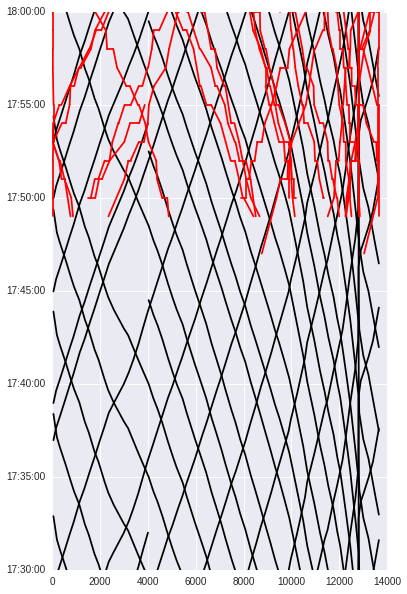

In [18]:


hs = [0]*len(sh_u)


plt.figure(figsize = (6, 10))
for i in time_inds:#Rt66Trips.index.values[:-12]:
    print i
    
    query_st = '''SELECT arrival_time, departure_time, StopsSel.stop_id AS stop_id, stop_seq, stop_lat, stop_lon FROM (
                    SELECT arrival_time, departure_time, stop_id, CAST(stop_sequence AS INT) AS stop_seq
                        FROM StopTimes WHERE trip_id == '''+Rt66Trips['trip_id'].loc[i]+'''  
                        ) AS StopsSel JOIN Stops ON StopsSel.stop_id == Stops.stop_id GROUP BY StopsSel.stop_id ORDER BY stop_seq ASC
    '''
    stops = pd.read_sql_query(query_st, con)
    stops['x'], stops['y'] = p1( np.array(stops['stop_lon']), np.array(stops['stop_lat']))
    
#    k = sh_u.index(Rt66Trips['shape_id'].loc[i])
#    plt.figure(k)
#    
#    if hs[k]==0:
#        hs[k]=1
#        plt.subplot(121)

    if i == Rt66Trips.index.values[0]:
        query_sh = '''SELECT * FROM (
                        SELECT shape_id, shape_pt_lat AS lat, shape_pt_lon AS lon, CAST(shape_pt_sequence AS INT) AS seq
                            FROM Shapes WHERE shape_id == '''+sh_u[k]+'''
                            )ORDER BY seq ASC
                '''
        shape = pd.read_sql_query(query_sh, con)
        shape['x'], shape['y'] = p1( np.array(shape['lon']), np.array(shape['lat']))
#        plt.plot(shape['x'], shape['y'])
#        axes = plt.gca()
#        axes.set_xlim([934000,948000])
#        axes.set_ylim([4650000,4653000])
        ind = min(enumerate(shape['x']), key=itemgetter(1))[0]
        ref_x = shape['x'][ind]
        ref_y = shape['y'][ind]
#    plt.subplot(122)
    stop_plot_x = np.array([0.0]*len(stops)*2)
    stop_plot_y = np.array([0.0]*len(stops)*2)
    stop_plot_t = ['']*len(stops)*2
    stop_plot_d = np.array([0.0]*len(stops)*2)

    dfi = stops.index.values
    stop_plot_x[0] = stops.loc[dfi[0]]['x']
    stop_plot_x[1] = stops.loc[dfi[0]]['x']
    stop_plot_y[0] = stops.loc[dfi[0]]['y']
    stop_plot_y[1] = stops.loc[dfi[0]]['y']
    stop_plot_t[0] = datetime.strptime(stops.loc[dfi[0]]['arrival_time'], '%H:%M:%S')
    stop_plot_t[1] = datetime.strptime(stops.loc[dfi[0]]['departure_time'], '%H:%M:%S')
    stop_plot_d[0] = p2p_dist([stop_plot_x[0],stop_plot_y[0]], [ref_x, ref_y])
    stop_plot_d[1] = stop_plot_d[0]

    for j in range(1,len(stops)):
        stop_plot_x[j*2] = stops.loc[dfi[j]]['x']
        stop_plot_x[j*2+1] = stops.loc[dfi[j]]['x']
        stop_plot_y[j*2] = stops.loc[dfi[j]]['y']
        stop_plot_y[j*2+1] = stops.loc[dfi[j]]['y']
        stop_plot_t[j*2] = datetime.strptime(stops.loc[dfi[j]]['arrival_time'], '%H:%M:%S')
        stop_plot_t[j*2+1] = datetime.strptime(stops.loc[dfi[j]]['departure_time'], '%H:%M:%S')    
        stop_plot_d[j*2] =  p2p_dist([stop_plot_x[j*2],stop_plot_y[j*2]], [ref_x, ref_y])
        stop_plot_d[j*2+1] = stop_plot_d[j*2]


    plt.plot_date(stop_plot_d, matplotlib.dates.date2num(stop_plot_t), 'k-', xdate=False, ydate=True)




base_url = 'http://www.ctabustracker.com/bustime/api/v1/'
route_str = 'getvehicles'
dev_str = 'iwAameW6cVPbv4PTdka8KEu3b'

from requests_futures.sessions import FuturesSession

session = FuturesSession(max_workers=5)
#urls = [url+route_str+'?key='+dev_str + '&rt='+ i for i in temp]
urls = [base_url+route_str+'?key='+dev_str + '&rt='+ '66']


futures = [session.get(url) for url in urls[:1]]
D = {}
for i in range(30):
    for future in futures:
        D = update_vehicle_dict(D,future.result())
    for j in D:
        if 'old_lat' in D[j]:
            x_old, y_old = p1( D[j]['old_lon'], D[j]['old_lat'])
            x_new, y_new = p1( D[j]['lon'], D[j]['lat'])
            dist_old = p2p_dist([x_old, y_old], [ref_x, ref_y])
            dist_new = p2p_dist([x_new, y_new], [ref_x, ref_y])
            t_old = matplotlib.dates.date2num(datetime.strptime(D[j]['tmstmp_old'][-5:], '%H:%M'))
            t_new = matplotlib.dates.date2num(datetime.strptime(D[j]['tmstmp'][-5:], '%H:%M'))
            plt.plot_date([dist_old, dist_new], [t_old, t_new], 'r-', xdate=False, ydate=True)#, markersize = 15)
    print i
    time.sleep(30)

axes = plt.gca()
axes.set_xlim([0,14000])
axes.set_ylim([693596.0 + 17.5/24.0, 693596.0+ 18.0/24.0])


(693596.7395833334, 693596.7583333333)

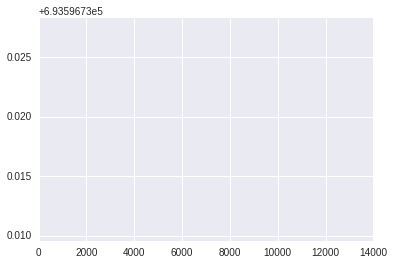

In [19]:
axes = plt.gca()
axes.set_xlim([0,14000])
axes.set_ylim([693596.0 + 17.75/24.0, 693596.0+ 18.2/24.0])


In [8]:
def update_vehicle_dict(D, response):
    root = ET.fromstring(urlopen(response.url).read())
    #print urlopen(response.url).read()
    new_keys = []
    for vehicle in root.findall('vehicle'):
        v_id = vehicle.find('vid').text
        new_keys.append(v_id)
        if not v_id in D:
            D[v_id] = {}
            for child in vehicle:
                D[v_id][child.tag] = child.text
        else:
            D[v_id]['old_lat'] = D[v_id]['lat']
            D[v_id]['old_lon'] = D[v_id]['lon']
            D[v_id]['lat'] = vehicle.find('lat').text
            D[v_id]['lon'] = vehicle.find('lon').text
            #print D[v_id]['old_lat'], D[v_id]['old_lon'], D[v_id]['lat'], D[v_id]['lon'],
            D[v_id]['tmstmp_old'] = D[v_id]['tmstmp']
            D[v_id]['tmstmp'] = vehicle.find('tmstmp').text
           
    rm = set(D.keys())-set(new_keys)
    [D.pop(i, None) for i in rm]
    return D




0
1
2
3
4


(693596.7083333334, 693596.75)

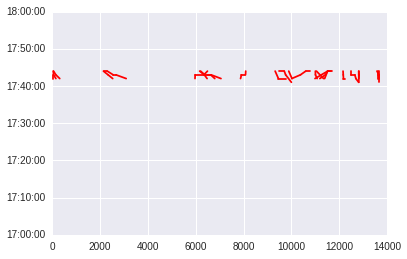

In [16]:

base_url = 'http://www.ctabustracker.com/bustime/api/v1/'
route_str = 'getvehicles'
dev_str = 'iwAameW6cVPbv4PTdka8KEu3b'

from requests_futures.sessions import FuturesSession

session = FuturesSession(max_workers=5)
#urls = [url+route_str+'?key='+dev_str + '&rt='+ i for i in temp]
urls = [base_url+route_str+'?key='+dev_str + '&rt='+ '66']


futures = [session.get(url) for url in urls[:1]]
D = {}
for i in range(5):
    for future in futures:
        D = update_vehicle_dict(D,future.result())
    for j in D:
        if 'old_lat' in D[j]:
            x_old, y_old = p1( D[j]['old_lon'], D[j]['old_lat'])
            x_new, y_new = p1( D[j]['lon'], D[j]['lat'])
            dist_old = p2p_dist([x_old, y_old], [ref_x, ref_y])
            dist_new = p2p_dist([x_new, y_new], [ref_x, ref_y])
            t_old = matplotlib.dates.date2num(datetime.strptime(D[j]['tmstmp_old'][-5:], '%H:%M'))
            t_new = matplotlib.dates.date2num(datetime.strptime(D[j]['tmstmp'][-5:], '%H:%M'))
            plt.plot_date([dist_old, dist_new], [t_old, t_new], 'r-', xdate=False, ydate=True)#, markersize = 15)
    print i
    time.sleep(30)

axes = plt.gca()
axes.set_xlim([0,14000])
axes.set_ylim([693596.0 + 17.0/24.0, 693596.0+ 18.0/24.0])
